### Install dependencies

In [1]:
# same deal for gdrive and kaggle
from google.colab import drive
drive.mount('/content/drive')

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/.kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle


Mounted at /content/drive
rm: cannot remove '/root/.kaggle': No such file or directory


In [2]:
# install dataset and unzip

!rm -r dataset

!kaggle datasets download -d saumitgp/occupancy-detection-dataset
!mkdir dataset
!unzip occupancy-detection-dataset.zip -d dataset

rm: cannot remove 'dataset': No such file or directory
  0% 0.00/213k [00:00<?, ?B/s]
100% 213k/213k [00:00<00:00, 30.7MB/s]
Archive:  occupancy-detection-dataset.zip
  inflating: dataset/OccupancyData/DataTest.csv  
  inflating: dataset/OccupancyData/DataTraining.csv  


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# the balance is weird, I will merge the train and test files first and split them to 8:2
df = pd.concat([
        pd.read_csv('dataset/OccupancyData/DataTraining.csv',index_col=[0]),
        pd.read_csv('dataset/OccupancyData/DataTest.csv',index_col=[0])
    ])
raw_vals = df.drop(columns=['date']).values
X,y = raw_vals[:,:-1],raw_vals[:,-1]
# pad X with 1 in the beginning, this will serve as our bias term
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=0)

# decision trees don't need scaling! :)

In [150]:
from tqdm.auto import tqdm
from sklearn.metrics import f1_score

def k_fold_validation(clf,X_train,y_train,n_folds=10):
    idxs = np.arange(X_train.shape[0])
    np.random.shuffle(idxs)
    folds = np.array_split(idxs,n_folds)
    all_scos = []
    for i in tqdm(range(n_folds),desc=f'{n_folds} folds validation...'):
        holdout = folds[i]
        rest = np.hstack([f for j,f in enumerate(folds) if not j == i])
        clf.fit(X_train[rest],y_train[rest])
        res = {
            'accuracy': clf.score(X_train[holdout],y_train[holdout]),
            'f1': f1_score(y_train[holdout],clf.predict(X_train[holdout]))
        }
        all_scos.append(res)
    return pd.DataFrame(all_scos)

### Task 1

Implement a Decision Tree Classifier for your classification problem. You may use a built-in package to implement your classifier. Try modifying one or more of the input parameters and describe what changes you notice in your results. Clearly describe how these factors are affecting your output.


I tried modifying some leaf conditions, complexity and depth of the tree. However, all the trees returned very simlar performance. I believe this was due to the dataset being too learnable.

In [158]:
from sklearn.tree import DecisionTreeClassifier

results = []
# maximum depth of the tree
for d in [2,3,4,5,6]:
    for l in [1,.2,.1]:
    # ccp_alpha, this is basically the complexity threshold
        # for alpha in [0,.1,.3]:
        params = {
            'random_state': 0,
            'max_depth': d,
            # 'ccp_alpha': alpha,
            'min_samples_leaf':l
        }
        tree = DecisionTreeClassifier(**params)

        train_res = k_fold_validation(tree,X_train,y_train).mean()

        tree.fit(X_train,y_train)
        results.append({
            **params,
            'train_acc': train_res.accuracy,
            'train_f1': train_res.f1,
            'test_acc': tree.score(X_test,y_test),
            'test_f1': f1_score(y_test,tree.predict(X_test)),
        })

results = pd.DataFrame(results)

results

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

,random_state,max_depth,min_samples_leaf,train_acc,train_f1,test_acc,test_f1
0,0,2,1.0,0.992316,0.981964,0.987427,0.971283
1,0,2,0.2,0.991757,0.980709,0.987147,0.970663
2,0,2,0.1,0.991618,0.980356,0.987147,0.970663
3,0,3,1.0,0.991897,0.980974,0.987427,0.971283
4,0,3,0.2,0.991757,0.980590,0.987147,0.970663
5,0,3,0.1,0.991618,0.980308,0.987147,0.970663
6,0,4,1.0,0.991967,0.981138,0.987147,0.970663
7,0,4,0.2,0.991758,0.980591,0.987147,0.970663
8,0,4,0.1,0.991757,0.980576,0.987147,0.970663
9,0,5,1.0,0.991618,0.980193,0.986309,0.968448


In [171]:
by_depth

,random_state,max_depth,min_samples_leaf,train_acc,train_f1,test_acc,test_f1
0,0,2,1.0,0.992316,0.981964,0.987427,0.971283
1,0,3,1.0,0.991897,0.980974,0.987427,0.971283
2,0,4,1.0,0.991967,0.981138,0.987147,0.970663
3,0,5,1.0,0.991618,0.980193,0.986309,0.968448
4,0,6,1.0,0.993434,0.984499,0.988544,0.973701


[(0.95, 1.0),
 [Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '4'),
  Text(0, 0, '5'),
  Text(0, 0, '6')],
 Text(0.5, 1.0, 'Test F1 by depth')]

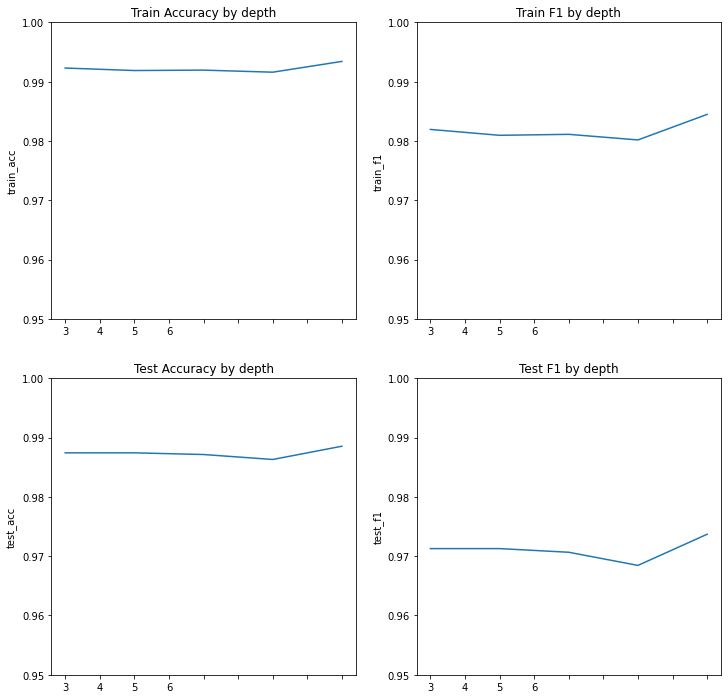

In [175]:
# plot by max depth
import matplotlib.pyplot as plt
import seaborn as sns

by_depth = results[results.min_samples_leaf == 1].reset_index(drop=True)
fig,axes = plt.subplots(ncols=2,nrows=2,figsize=(12,12))
sns.lineplot(data=by_depth.train_acc,ax=axes[0,0]).set(xticklabels=by_depth.max_depth.values,ylim=(.95,1),title='Train Accuracy by depth')
sns.lineplot(data=by_depth.train_f1,ax=axes[0,1]).set(xticklabels=by_depth.max_depth.values,ylim=(.95,1),title='Train F1 by depth')
sns.lineplot(data=by_depth.test_acc,ax=axes[1,0]).set(xticklabels=by_depth.max_depth.values,ylim=(.95,1),title='Test Accuracy by depth')
sns.lineplot(data=by_depth.test_f1,ax=axes[1,1]).set(xticklabels=by_depth.max_depth.values,ylim=(.95,1),title='Test F1 by depth')

In [169]:
by_split

,random_state,max_depth,min_samples_leaf,train_acc,train_f1,test_acc,test_f1
3,0,3,1.0,0.991897,0.980974,0.987427,0.971283
4,0,3,0.2,0.991757,0.980590,0.987147,0.970663
5,0,3,0.1,0.991618,0.980308,0.987147,0.970663


[(0.95, 1.0),
 [Text(0, 0, '1.0'), Text(0, 0, '0.2'), Text(0, 0, '0.1')],
 Text(0.5, 1.0, 'Test F1 by leaf split')]

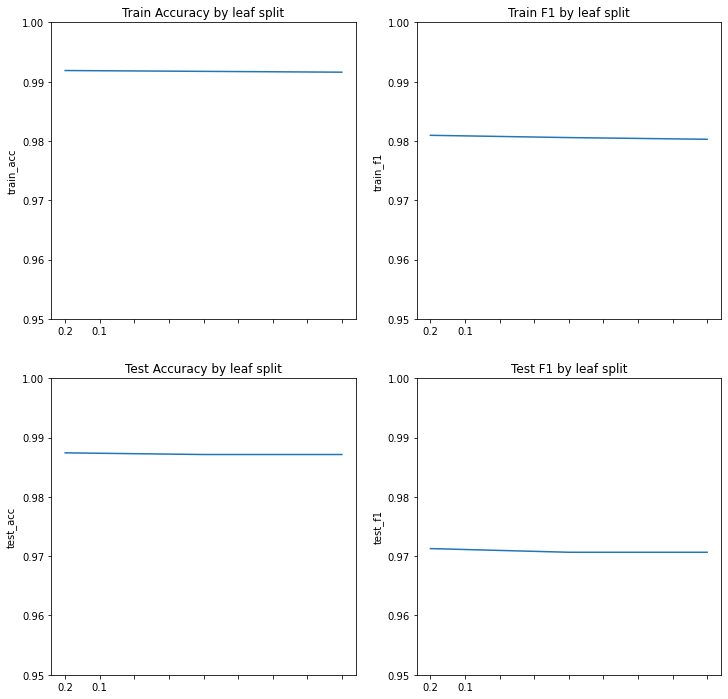

In [168]:
# plot by max depth
import matplotlib.pyplot as plt
import seaborn as sns

by_split = results[results.max_depth == 3]
fig,axes = plt.subplots(ncols=2,nrows=2,figsize=(12,12))
sns.lineplot(data=by_split.train_acc,ax=axes[0,0]).set(xticklabels=by_split.min_samples_leaf,ylim=(.95,1),title='Train Accuracy by leaf split')
sns.lineplot(data=by_split.train_f1,ax=axes[0,1]).set(xticklabels=by_split.min_samples_leaf,ylim=(.95,1),title='Train F1 by leaf split')
sns.lineplot(data=by_split.test_acc,ax=axes[1,0]).set(xticklabels=by_split.min_samples_leaf,ylim=(.95,1),title='Test Accuracy by leaf split')
sns.lineplot(data=by_split.test_f1,ax=axes[1,1]).set(xticklabels=by_split.min_samples_leaf,ylim=(.95,1),title='Test F1 by leaf split')

### Task 2

From the Bagging and Boosting ensemble methods pick any one algorithm 
from each category. Implement both the algorithms using the same data. Use k-fold cross 
validation to find the effectiveness of both the models. Comment on the difference/similarity of 
the results.

In [8]:
# bagging
# n_bags = 50
class BaggedTree:
    def __init__(self,n_bags):
        self.n_bags = n_bags
        self.bagged_models = []
    def fit(self,X_train,y_train):
        idxs = np.arange(X_train.shape[0])
        for _ in range(self.n_bags):
            subset = np.random.choice(idxs,X_train.shape[0] // self.n_bags )
            X_sub,y_sub = X_train[subset],y_train[subset]
            # Although this dataset is easier to learn, don't want the trees to overfit! 
            self.bagged_models.append(DecisionTreeClassifier(max_depth=4).fit(X_sub,y_sub))
        # now testing the mdoel
        return self
    def predict(self,X_test):
        # in this case, since the trees predict between 0 and 1, we split from .5
        return (np.vstack([m.predict(X_test) for m in self.bagged_models]).mean(0) > .5).astype(int)
        # accuracy = (preds == y_test).mean()
    def score(self,X_test,y_test):
        return (self.predict(X_test) == y_test).mean()


In [123]:
# Adaboost implementation
# this one takes a bit longer

class AdaBoost:
    def __init__(self,n_models,n_iter=100):
        self.n_models = n_models
        self.boosted_models = [DecisionTreeClassifier(max_depth=1,random_state=0)] * n_models
        self.alphas = np.ones(n_models)
        self.n_iter = n_iter
    def fit(self,X_train,y_train):
        weights = np.ones_like(y_train) / y_train.shape[0]
        # for _ in tqdm(range(self.n_iter),desc='AdaBoost training...'):
        for i,m in enumerate(self.boosted_models):
            m.fit(X_train,y_train,sample_weight=weights)
            y_pred = m.predict(X_train)
            # identify missed examples
            misses = y_train * y_pred
            # calculate overall err
            err = (weights * misses).sum() / weights.sum()
            # reweight
            alpha = np.log((1-err)/err) * .5
            self.alphas[i] = alpha
            weights *= np.exp(alpha * misses)
            # weights should always sum to 1
            weights /= weights.sum()
        return self
    def predict(self,X_test):
        outs = np.vstack([m.predict(X_test) for m in self.boosted_models])
        # although I have been using 0 and 1 for labels, for the convenience of caculating final outcome, 
        # the labels are temporarily converted to -1 and 1. 
        outs[outs==0] = -1
        return ((outs * self.alphas[:,None]).sum(0) > 0).astype(int)
    def score(self,X_test,y_test):
        return (self.predict(X_test) == y_test).mean()
 


In [172]:
BAGS_TO_TRY = [1,2,10,20,50,100,200]
BOOSTS_TO_TRY = [1,2,5,10,20,50,100,200]

bagged_avgs = pd.concat([
    k_fold_validation(BaggedTree(n),X_train,y_train).mean()
    for n in BAGS_TO_TRY
],axis=1).T

print('bagging results:')
print(bagged_avgs)


ada_avgs = pd.concat([
    k_fold_validation(AdaBoost(n,n_iter=10),X_train,y_train).mean()
    for n in BOOSTS_TO_TRY
],axis=1).T

print('boosting results:')
print(ada_avgs)


10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

bagging results:
   accuracy        f1
0  0.992735  0.982858
1  0.992316  0.981934
2  0.992107  0.981527
3  0.991827  0.980955
4  0.991758  0.980604
5  0.991827  0.980781
6  0.991618  0.980415


10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

boosting results:
   accuracy        f1
0  0.991758  0.980624
1  0.991688  0.980474
2  0.991618  0.980219
3  0.991548  0.980153
4  0.991828  0.980852
5  0.991757  0.980573
6  0.991618  0.980322
7  0.991758  0.980718


[(0.95, 1.0),
 [Text(0, 0, '1'),
  Text(0, 0, '2'),
  Text(0, 0, '5'),
  Text(0, 0, '10'),
  Text(0, 0, '20'),
  Text(0, 0, '50'),
  Text(0, 0, '100'),
  Text(0, 0, '200')],
 Text(0.5, 1.0, 'AdaBoost trees F1')]

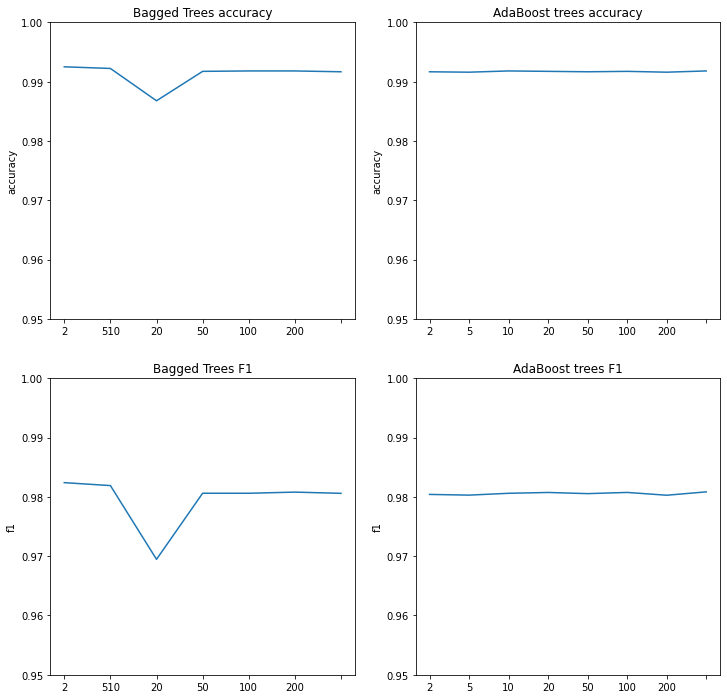

In [147]:
fig,axes = plt.subplots(nrows=2, ncols = 2,figsize =(12,12))

# bagging is doing a bit too well and we can't tell. so setting the lims between .98 and 1
sns.lineplot(data=bagged_avgs.accuracy, ax=axes[0,0]).set(ylim=(.95,1),title='Bagged Trees accuracy',xticklabels=BAGS_TO_TRY)
sns.lineplot(data=bagged_avgs.f1, ax=axes[1,0]).set(ylim=(.95,1),title='Bagged Trees F1',xticklabels=BAGS_TO_TRY)

sns.lineplot(data=ada_avgs.accuracy, ax=axes[0,1]).set(ylim=(.95,1), title='AdaBoost trees accuracy',xticklabels=BOOSTS_TO_TRY)
sns.lineplot(data=ada_avgs.f1, ax=axes[1,1]).set(ylim=(.95,1), title='AdaBoost trees F1',xticklabels=BOOSTS_TO_TRY)



### Task 3

Compare the effectiveness of the three models implemented above. Clearly 
describe the metric you are using for comparison. Describe (with examples) Why is this 
metric(metrics) suited/appropriate for the problem at hand? How would a choice of a different 
metric impact your results? Can you demonstrate that.



I made use of the F1 score and the classic accuracy score to check the effectiveness of the models. From what I can tell, it seems that 